[   1.            1.          335.85231005]
      Channel  Counts         Fit
1000     1000    3945  335.852310
1001     1001    3878  335.852310
1002     1002    3936  335.852310
1003     1003    3910  335.852310
1004     1004    3932  335.852310
1005     1005    3882  335.852310
1006     1006    3979  335.852310
1007     1007    3963  335.852310
1008     1008    4015  335.852310
1009     1009    3981  335.852310
1010     1010    3833  335.852310
1011     1011    3919  335.852310
1012     1012    3940  335.852310
1013     1013    3760  335.852310
1014     1014    3845  335.852310
1015     1015    3852  335.852310
1016     1016    3845  335.852310
1017     1017    3927  335.852310
1018     1018    3852  335.852310
1019     1019    3916  335.852310
1020     1020    3830  335.852310
1021     1021    3883  335.852310
1022     1022    3886  335.852310
1023     1023    3736  335.852310
1024     1024    3877  335.852310
1025     1025    3767  335.852310
1026     1026    3859  335.852310
1027

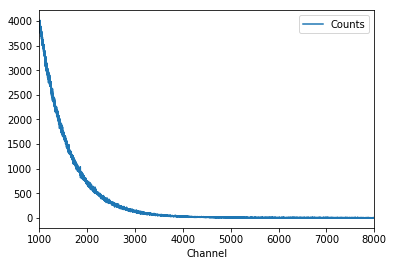

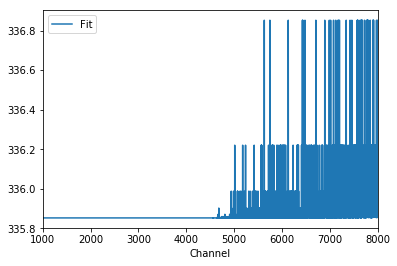

In [33]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

MIN_RANGE=1000
MAX_RANGE=8000

def exp_fit(count, a, b, c):
    return a * np.exp(-b*count) + c

data = pandas.read_csv('data/lifetime.csv')

actual_data = data.loc[(data['Channel'] >= MIN_RANGE) & (data['Channel'] <= MAX_RANGE), ['Channel', 'Counts']]
popt, pcov = curve_fit(exp_fit, actual_data['Channel'], actual_data['Counts'])
actual_data['Fit'] = actual_data['Counts'].apply(lambda count: exp_fit(count, popt[0], popt[1], popt[2]))

print popt
print actual_data

actual_data.plot(
    x='Channel',
    y='Counts'
)

actual_data.plot(
    x='Channel',
    y='Fit'
)

plt.show()